In [1]:
# Import libraries
from cil.framework import  AcquisitionGeometry
from cil.optimisation.functions import L2NormSquared, BlockFunction, MixedL21Norm, IndicatorBox
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.algorithms import PDHG
from cil.plugins.astra.operators import ProjectionOperator
from cil.utilities.display import show2D
from cil.utilities import dataexample
from cil.plugins.astra.utilities import convert_geometry_to_astra

import matplotlib.pyplot as plt

from cvxpy import *
import astra

import numpy as np

## Create AcquisitionGeometry, ImageGeometry and ProjectionOperator

In [2]:
# Detectors
N = 32
detectors =  N

# Angles
angles = np.linspace(0,180,90, dtype='float32')

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles)\
                        .set_panel(detectors)
# Get image geometry
ig = ag.get_ImageGeometry()

# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = ProjectionOperator(ig, ag, device = 'cpu')

## Create phantom

In [3]:
# Get phantom
phantom = dataexample.SIMPLE_PHANTOM_2D.get(size=(N, N))

## Create sinogram 

In [4]:
# Create an acqusition data
sino = A.direct(phantom)

## Get sparse projection matrix from the ProjectionOperator

In [5]:
# convert to astra geometries
ig_astra, ag_astra = convert_geometry_to_astra(ig, ag)

# projection id
proj_id = astra.create_projector('line', ag_astra, ig_astra)

# matrix id
matrix_id = astra.projector.matrix(proj_id)

# Get the projection matrix as a Scipy sparse matrix.
W = astra.matrix.get(matrix_id)

## Compare matrix-free with matrix*vector implementation

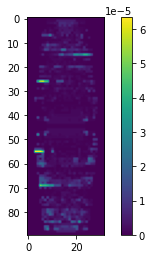

In [6]:
sino_astra = np.reshape(W*phantom.array.ravel(),ag.shape)
plt.figure()
plt.imshow(np.abs(sino.array-sino_astra))
plt.colorbar()
plt.show()

## Regularisation parameter for TV regularisation

In [7]:
alpha = 100

## Solve with cvxpy

To solve with cvxpy, we need a matrix representation of the ProjectionOperator.

An alternative is to use [ProxImal](https://github.com/comp-imaging/ProxImaL) library as a matrix-free option.

In [8]:
N, M = ig.shape
u_cvx = Variable(N*M)
fidelity = sum_squares(W@u_cvx.flatten() - sino.array.flatten())
constraints = [u_cvx>=0]

regulariser = (alpha) * tv(reshape(u_cvx, (N,M))) 
obj =  Minimize( regulariser +  fidelity)
prob = Problem(obj, constraints)

res = prob.solve(verbose = True, solver = SCS, eps=1e-4)

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) Dec 15 08:21:24 AM: Your problem has 1024 variables, 1 constraints, and 0 parameters.
(CVXPY) Dec 15 08:21:24 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 15 08:21:24 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 15 08:21:24 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 15 08:21:24 AM: Compiling problem (target solver=SCS).
(CVXPY) Dec 15 08:21:24 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

## Solve with CIL using the PDHG algorithm

In [9]:
# Setup PDHG

# separable sum
f1 = L2NormSquared(b=sino)
f2 = alpha * MixedL21Norm()
f = BlockFunction(f1, f2)

# non-negativity constraint
g = IndicatorBox(lower=0.0)
Grad = GradientOperator(ig)

# BlockOperator
K = BlockOperator(A, Grad)

# stepsize
sigma = 10

# Run PDHG
pdhg = PDHG(f = f, g = g, operator = K, update_objective_interval=500, max_iteration=3000, sigma=sigma)
pdhg.run(verbose=2) 
u_cil = pdhg.solution

Initialised GradientOperator with C backend running with  20  threads
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       3000         0.000    3.25987e+05  -0.00000e+00    3.25987e+05


/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/framework/framework.py:2421: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      500       3000         0.007    6.88734e+03   5.73411e+03    1.15323e+03
     1000       3000         0.008    6.71964e+03   6.36772e+03    3.51920e+02
     1500       3000         0.008    6.68013e+03   6.53405e+03    1.46077e+02
     2000       3000         0.008    6.65576e+03   6.58625e+03    6.95139e+01
     2500       3000         0.008    6.64719e+03   6.61190e+03    3.52965e+01
     3000       3000         0.008    6.64371e+03   6.62034e+03    2.33727e+01
----------------------------------------------------------------------------
     3000       3000         0.008    6.64371e+03   6.62034e+03    2.33727e+01
Stop criterion has been reached.



CVX objective = 6641.616740187816
CIL objective = 6643.71435546875


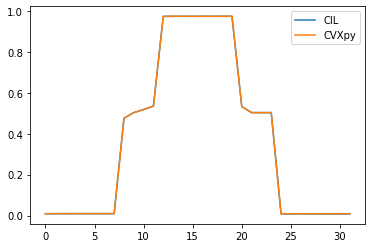

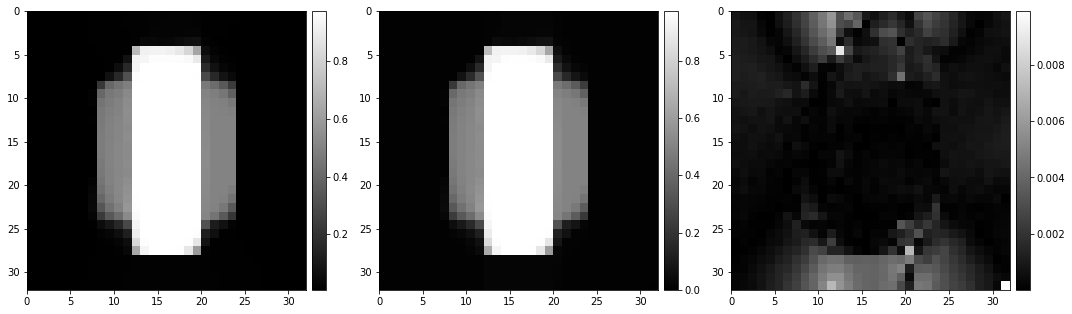

In [10]:
# reshape cvxpy solution
u_cvx_arr = u_cvx.value.reshape(ig.shape)

# print objectives
print("CVX objective = {}".format(obj.value))

print("CIL objective = {}".format(pdhg.objective[-1]))

# show middle line profiles

plt.figure()
plt.plot(u_cil.array[int(N/2)], label="CIL")
plt.plot(u_cvx_arr[int(N/2)], label="CVXpy")
plt.legend()
plt.show()

show2D([u_cil.array, u_cvx_arr, np.abs(u_cil.array - u_cvx_arr)], num_cols = 3, origin="upper")

# compare solution
np.testing.assert_almost_equal(u_cil.array, u_cvx_arr, decimal=2)